---
# 🎨 DCGAN with CelebA (TensorFlow)

**학습 목표:**
- Kaggle에서 CelebA 데이터셋 다운로드
- L4 GPU 리소스 최적화 (BATCH_SIZE=256)
- 고품질 얼굴 이미지 생성

**환경:**
- Google Colab L4 GPU (24GB)
- TensorFlow 2.x
- Mixed Precision Training
---

## 1️⃣ Kaggle API 설정 및 데이터셋 다운로드

In [1]:
# Kaggle API 설치
!pip install -q kaggle

In [2]:
# Kaggle 인증 정보 설정
import os
os.environ["KAGGLE_USERNAME"] = "taekyunkim97"
os.environ["KAGGLE_KEY"] = "KGAT_167b4f48e9a62a86cd5c752de9ffe1be"

print("✅ Kaggle API 인증 완료")

✅ Kaggle API 인증 완료


In [4]:
# CelebA 데이터셋 다운로드
print("📥 CelebA 데이터셋 다운로드 중...")
print("(약 1.3GB - 시간이 소요됩니다)")

# 디렉토리 생성
!mkdir -p celeba

# Kaggle에서 다운로드
!kaggle datasets download -d jessicali9530/celeba-dataset -p ./celeba -q

# 압축 해제
print("\n📦 압축 해제 중...")
!unzip -q ./celeba/celeba-dataset.zip -d ./celeba

print("\n✅ 데이터셋 다운로드 완료")

📥 CelebA 데이터셋 다운로드 중...
(약 1.3GB - 시간이 소요됩니다)
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
User cancelled operation

📦 압축 해제 중...
replace ./celeba/img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
✅ 데이터셋 다운로드 완료


## 2️⃣ 환경 설정 및 라이브러리 임포트

In [5]:
# 필요한 라이브러리 임포트
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import time
from IPython.display import clear_output

# GPU 확인 및 설정
print(f"TensorFlow 버전: {tf.__version__}")
print(f"GPU 사용 가능: {tf.config.list_physical_devices('GPU')}")

# GPU 메모리 증가 허용 (OOM 방지)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU 메모리 동적 할당 설정 완료")
    except RuntimeError as e:
        print(e)

# Mixed Precision 설정 (L4 GPU 최적화)
USE_MIXED_PRECISION = True

if USE_MIXED_PRECISION:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print(f"✅ Mixed Precision 활성화: {policy.name}")
    print(f"   - Compute dtype: {policy.compute_dtype}")
    print(f"   - Variable dtype: {policy.variable_dtype}")

# 랜덤 시드 설정
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow 버전: 2.19.0
GPU 사용 가능: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU 메모리 동적 할당 설정 완료
✅ Mixed Precision 활성화: mixed_float16
   - Compute dtype: float16
   - Variable dtype: float32


## 3️⃣ 하이퍼파라미터 설정 (GPU 최적화)

In [6]:
# ========================================
# 하이퍼파라미터 설정
# ========================================
# L4 GPU: 24GB VRAM, Tensor Core 지원
# BATCH_SIZE를 256으로 증가 (GPU 메모리 효율적 사용)

# 이미지 설정
IMG_SIZE = 64  # CelebA 표준: 64×64
CHANNELS = 3  # RGB

# 학습 설정
BATCH_SIZE = 256  # 128 → 256 증가 (GPU 메모리 15~18GB 사용 예상)
NOISE_DIM = 100  # 노이즈 벡터 차원
EPOCHS = 50  # 총 학습 에폭

# Optimizer 설정 (DCGAN 표준)
LR_G = 0.0002  # Generator 학습률
LR_D = 0.0002  # Discriminator 학습률
BETA1 = 0.5  # Adam optimizer beta1
BETA2 = 0.999  # Adam optimizer beta2

# 출력 설정
SAVE_INTERVAL = 3  # 이미지 생성 간격 (에폭)
DISPLAY_INTERVAL = 50  # Loss 출력 간격 (배치)

print("=" * 60)
print("🔧 하이퍼파라미터 설정")
print("=" * 60)
print(f"이미지 크기: {IMG_SIZE}×{IMG_SIZE}×{CHANNELS}")
print(f"배치 크기: {BATCH_SIZE} (GPU 최적화)")
print(f"노이즈 차원: {NOISE_DIM}")
print(f"학습 에폭: {EPOCHS}")
print(f"학습률 (G/D): {LR_G} / {LR_D}")
print(f"Mixed Precision: {USE_MIXED_PRECISION}")
print("=" * 60)

🔧 하이퍼파라미터 설정
이미지 크기: 64×64×3
배치 크기: 256 (GPU 최적화)
노이즈 차원: 100
학습 에폭: 50
학습률 (G/D): 0.0002 / 0.0002
Mixed Precision: True


## 4️⃣ 데이터셋 로드 및 전처리

In [7]:
# ========================================
# 이미지 경로 수집
# ========================================
DATA_DIR = pathlib.Path("celeba") / "img_align_celeba" / "img_align_celeba"

# 모든 이미지 경로 수집
all_image_paths = sorted(str(p) for p in DATA_DIR.glob("*.jpg"))
num_images = len(all_image_paths)

print("\n📊 데이터셋 통계")
print("=" * 50)
print(f"총 이미지 개수: {num_images:,}장")
print(f"데이터 경로: {DATA_DIR}")
print("=" * 50)


📊 데이터셋 통계
총 이미지 개수: 202,599장
데이터 경로: celeba/img_align_celeba/img_align_celeba


In [8]:
# ========================================
# 이미지 로드 함수
# ========================================
def load_image_from_path(path):
    """
    이미지 경로에서 이미지를 로드하여 딕셔너리 형태로 반환

    Args:
        path: 이미지 파일 경로 (str)

    Returns:
        dict: {'image': Tensor} 형태
              - image shape: (218, 178, 3)
              - dtype: uint8
              - 범위: [0, 255]
    """
    # 이미지 파일 읽기
    img_bytes = tf.io.read_file(path)

    # JPEG 디코딩
    image = tf.image.decode_jpeg(img_bytes, channels=3)
    # 결과 shape: (218, 178, 3), dtype: uint8

    return {"image": image}


# ========================================
# 데이터 전처리 함수
# ========================================
def preprocess_image(data):
    """
    CelebA 이미지 전처리

    Args:
        data: {'image': Tensor} 형태의 데이터

    Returns:
        전처리된 이미지 Tensor (64, 64, 3), 범위 [-1, 1]

    전처리 단계:
        1. 딕셔너리에서 이미지 추출
        2. 얼굴 중심 Crop (218×178 → 140×140)
        3. Resize (140×140 → 64×64)
        4. 정규화 ([0, 255] → [-1, 1])
    """
    # 1. 이미지 추출
    # 원본 shape: (218, 178, 3), dtype: uint8, 범위: [0, 255]
    image = data['image']

    # 2. 얼굴 중심 부분 Crop
    # CelebA 이미지는 218×178 크기이며, 얼굴이 중앙에 위치
    # 140×140 정사각형으로 crop하여 얼굴 영역만 추출
    image = tf.image.crop_to_bounding_box(
        image,
        offset_height=40,  # 위에서 40픽셀 아래부터
        offset_width=20,   # 왼쪽에서 20픽셀 오른쪽부터
        target_height=140,  # 높이 140픽셀
        target_width=140    # 너비 140픽셀
    )
    # 결과 shape: (140, 140, 3)

    # 3. 64×64로 Resize (학습 속도 향상)
    image = tf.image.resize(
        image,
        [IMG_SIZE, IMG_SIZE],
        method='bilinear',  # 양선형 보간
        antialias=True      # 앨리어싱 방지 (품질 향상)
    )
    # 결과 shape: (64, 64, 3)

    # 4. 정규화: [0, 255] → [-1, 1]
    # Tanh 활성화 함수 출력 범위와 일치시킴
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    # 결과 shape: (64, 64, 3), dtype: float32, 범위: [-1, 1]

    return image


# ========================================
# 데이터 파이프라인 구성 (성능 최적화)
# ========================================
def prepare_dataset(dataset, batch_size, buffer_size=10000):
    """
    학습용 데이터 파이프라인 구성

    Args:
        dataset: tf.data.Dataset
        batch_size: 배치 크기
        buffer_size: 셔플 버퍼 크기

    Returns:
        최적화된 tf.data.Dataset

    최적화 기법:
        - map: 병렬 전처리 (num_parallel_calls=AUTOTUNE)
        - cache: 메모리 캐싱 (첫 에폭 후 재사용)
        - shuffle: 데이터 셔플링
        - batch: 배치 생성
        - prefetch: 백그라운드 데이터 로딩
    """
    # 전처리 적용 (병렬 처리)
    dataset = dataset.map(
        preprocess_image,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False
    )

    # 메모리 캐싱 (첫 에폭 후 재전처리 방지)
    dataset = dataset.cache()

    # 셔플링 (에폭마다 순서 변경)
    dataset = dataset.shuffle(buffer_size)

    # 배치 생성
    dataset = dataset.batch(batch_size, drop_remainder=True)

    # Prefetch (CPU에서 다음 배치를 미리 준비)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


# ========================================
# 파이프라인 구성
# ========================================
print("\n🔄 데이터 파이프라인 구성 중...")

# 파일 경로 리스트를 Dataset으로 변환
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

# 이미지 로드
raw_ds = path_ds.map(
    load_image_from_path,
    num_parallel_calls=tf.data.AUTOTUNE
)

# 전처리 및 배치 처리
train_dataset = prepare_dataset(raw_ds, BATCH_SIZE)

print(f"\n✅ 데이터 파이프라인 구성 완료")
print(f"   - 배치 크기: {BATCH_SIZE}")
print(f"   - 총 배치 수: {num_images // BATCH_SIZE}")
print(f"   - 캐싱: 활성화")
print(f"   - Prefetch: 활성화")


🔄 데이터 파이프라인 구성 중...

✅ 데이터 파이프라인 구성 완료
   - 배치 크기: 256
   - 총 배치 수: 791
   - 캐싱: 활성화
   - Prefetch: 활성화



🎨 데이터 샘플 확인
배치 shape: (256, 64, 64, 3)
배치 dtype: <dtype: 'float32'>
값 범위: [-1.00, 1.00]


/tmp/ipython-input-4260218602.py:22: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4260218602.py:22: UserWarning: Glyph 52376 (\N{HANGUL SYLLABLE CEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4260218602.py:22: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4260218602.py:22: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4260218602.py:22: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning

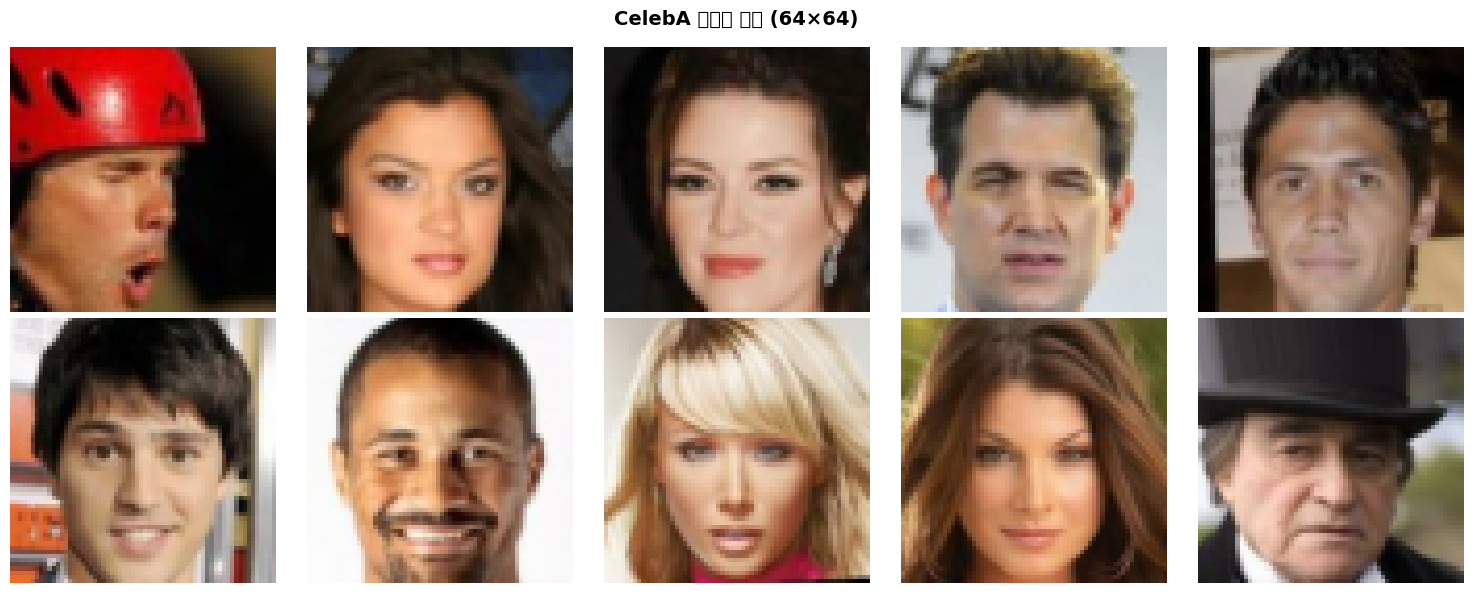

In [9]:
# ========================================
# 데이터 샘플 시각화
# ========================================
print("\n🎨 데이터 샘플 확인")

# 첫 번째 배치 가져오기
sample_batch = next(iter(train_dataset))
print(f"배치 shape: {sample_batch.shape}")  # (256, 64, 64, 3)
print(f"배치 dtype: {sample_batch.dtype}")  # float32
print(f"값 범위: [{sample_batch.numpy().min():.2f}, {sample_batch.numpy().max():.2f}]")

# 시각화
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # [-1, 1] → [0, 1] 변환
    img = (sample_batch[i].numpy() + 1) / 2
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')

plt.suptitle("CelebA 전처리 샘플 (64×64)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5️⃣ Generator 구현 (DCGAN 아키텍처)

In [10]:
def build_generator(noise_dim=100):
    """
    DCGAN Generator 구현

    아키텍처:
        Input: 노이즈 벡터 (batch_size, 100)
        Layer 1: Dense(4×4×1024) + Reshape → (batch_size, 4, 4, 1024)
        Layer 2: ConvTranspose2D(512) + BN + ReLU → (batch_size, 8, 8, 512)
        Layer 3: ConvTranspose2D(256) + BN + ReLU → (batch_size, 16, 16, 256)
        Layer 4: ConvTranspose2D(128) + BN + ReLU → (batch_size, 32, 32, 128)
        Layer 5: ConvTranspose2D(3) + Tanh → (batch_size, 64, 64, 3)
    """

    model = tf.keras.Sequential(name='Generator')

    # Layer 1: Dense + Reshape
    model.add(layers.Dense(
        units=4 * 4 * 1024,
        use_bias=False,
        input_shape=(noise_dim,),
        name='dense_project'
    ))
    model.add(layers.BatchNormalization(name='bn_project'))
    model.add(layers.ReLU(name='relu_project'))
    model.add(layers.Reshape((4, 4, 1024), name='reshape'))

    # Layer 2: ConvTranspose2D (4×4 → 8×8)
    model.add(layers.Conv2DTranspose(
        filters=512,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=False,
        name='deconv_1'
    ))
    model.add(layers.BatchNormalization(name='bn_1'))
    model.add(layers.ReLU(name='relu_1'))

    # Layer 3: ConvTranspose2D (8×8 → 16×16)
    model.add(layers.Conv2DTranspose(
        filters=256,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=False,
        name='deconv_2'
    ))
    model.add(layers.BatchNormalization(name='bn_2'))
    model.add(layers.ReLU(name='relu_2'))

    # Layer 4: ConvTranspose2D (16×16 → 32×32)
    model.add(layers.Conv2DTranspose(
        filters=128,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=False,
        name='deconv_3'
    ))
    model.add(layers.BatchNormalization(name='bn_3'))
    model.add(layers.ReLU(name='relu_3'))

    # Layer 5: ConvTranspose2D (32×32 → 64×64) - 출력층
    model.add(layers.Conv2DTranspose(
        filters=3,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=False,
        activation='tanh',
        name='output',
        dtype='float32'
    ))

    return model


# Generator 생성
generator = build_generator(NOISE_DIM)

print("\n📊 Generator 구조:")
print("=" * 60)
generator.summary()
print("=" * 60)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📊 Generator 구조:


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_project (Dense)           │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_project (BatchNormalization) │ (None, 16384)          │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_project (ReLU)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_1 (Conv2DTranspose)      │ (None, 8, 8, 512)      │    13,107,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 8, 8, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (ReLU)                   │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_2 (Conv2DTranspose)      │ (None, 16, 16, 256)    │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 16, 16, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (ReLU)                   │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_3 (Conv2DTranspose)      │ (None, 32, 32, 128)    │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (ReLU)                   │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv2DTranspose)        │ (None, 64, 64, 3)      │         9,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,920,320 (72.18 MB)

 Trainable params: 18,885,760 (72.04 MB)

 Non-trainable params: 34,560 (135.00 KB)

## 6️⃣ Discriminator 구현 (DCGAN 아키텍처)

In [11]:
def build_discriminator():
    """
    DCGAN Discriminator 구현

    아키텍처:
        Input: 이미지 (batch_size, 64, 64, 3)
        Layer 1: Conv2D(64) + LeakyReLU → (batch_size, 32, 32, 64)
        Layer 2: Conv2D(128) + BN + LeakyReLU → (batch_size, 16, 16, 128)
        Layer 3: Conv2D(256) + BN + LeakyReLU → (batch_size, 8, 8, 256)
        Layer 4: Conv2D(512) + BN + LeakyReLU → (batch_size, 4, 4, 512)
        Layer 5: Flatten + Dense(1) → (batch_size, 1)
    """

    model = tf.keras.Sequential(name='Discriminator')

    # Layer 1: Conv2D (64×64 → 32×32) - 입력층
    model.add(layers.Conv2D(
        filters=64,
        kernel_size=5,
        strides=2,
        padding='same',
        input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
        use_bias=False,
        name='conv_1'
    ))
    model.add(layers.LeakyReLU(0.2, name='lrelu_1'))

    # Layer 2: Conv2D (32×32 → 16×16)
    model.add(layers.Conv2D(
        filters=128,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=False,
        name='conv_2'
    ))
    model.add(layers.BatchNormalization(name='bn_2'))
    model.add(layers.LeakyReLU(0.2, name='lrelu_2'))

    # Layer 3: Conv2D (16×16 → 8×8)
    model.add(layers.Conv2D(
        filters=256,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=False,
        name='conv_3'
    ))
    model.add(layers.BatchNormalization(name='bn_3'))
    model.add(layers.LeakyReLU(0.2, name='lrelu_3'))

    # Layer 4: Conv2D (8×8 → 4×4)
    model.add(layers.Conv2D(
        filters=512,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=False,
        name='conv_4'
    ))
    model.add(layers.BatchNormalization(name='bn_4'))
    model.add(layers.LeakyReLU(0.2, name='lrelu_4'))

    # Layer 5: Flatten + Dense(1) - 출력층
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(
        units=1,
        name='output',
        dtype='float32'
    ))

    return model


# Discriminator 생성
discriminator = build_discriminator()

print("\n📊 Discriminator 구조:")
print("=" * 60)
discriminator.summary()
print("=" * 60)


📊 Discriminator 구조:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_1 (LeakyReLU)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 128)    │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_2 (LeakyReLU)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 256)      │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_3 (LeakyReLU)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 4, 4, 512)      │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 4, 4, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_4 (LeakyReLU)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,317,377 (16.47 MB)

 Trainable params: 4,315,585 (16.46 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 7️⃣ 손실 함수 및 Optimizer 설정

In [12]:
# Binary Cross Entropy with Logits
cross_entropy = tf.keras.losses.BinaryCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.NONE
)


def discriminator_loss(real_output, fake_output):
    """Discriminator 손실 함수"""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = tf.reduce_mean(real_loss + fake_loss)
    return total_loss


def generator_loss(fake_output):
    """Generator 손실 함수"""
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return tf.reduce_mean(loss)


# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR_G,
    beta_1=BETA1,
    beta_2=BETA2,
    name='Adam_Generator'
)

discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR_D,
    beta_1=BETA1,
    beta_2=BETA2,
    name='Adam_Discriminator'
)

print("✅ 손실 함수 및 Optimizer 설정 완료")

✅ 손실 함수 및 Optimizer 설정 완료


## 8️⃣ 학습 Step 함수 구현

In [13]:
@tf.function
def train_step(real_images):
    """DCGAN 한 스텝 학습"""
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, NOISE_DIM])

    # Discriminator 학습
    with tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        d_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(
        d_loss, discriminator.trainable_variables
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    # Generator 학습
    noise = tf.random.normal([batch_size, NOISE_DIM])

    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        g_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(
        g_loss, generator.trainable_variables
    )
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )

    return d_loss, g_loss


print("✅ train_step 함수 정의 완료")

✅ train_step 함수 정의 완료


## 9️⃣ 이미지 생성 및 시각화 함수

🎨 학습 전 Generator 출력


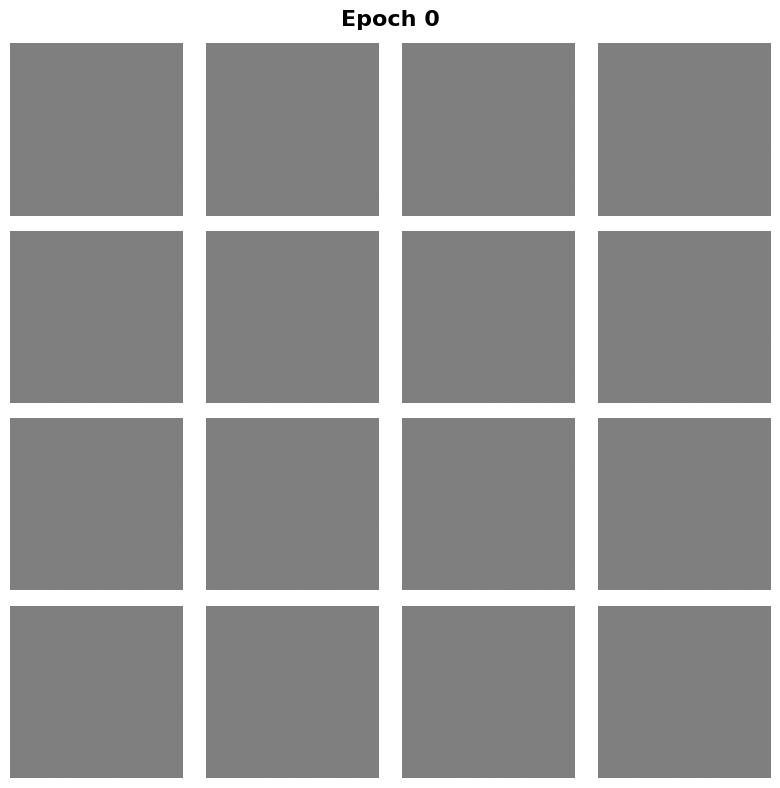

In [14]:
# 고정 노이즈 시드
num_examples_to_generate = 16
fixed_seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])


def generate_and_save_images(epoch, generator, seed):
    """Generator로 이미지 생성 및 시각화"""
    predictions = generator(seed, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i].numpy() + 1) / 2
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# 초기 이미지 생성
print("🎨 학습 전 Generator 출력")
generate_and_save_images(0, generator, fixed_seed)

## 🔟 전체 학습 루프 실행

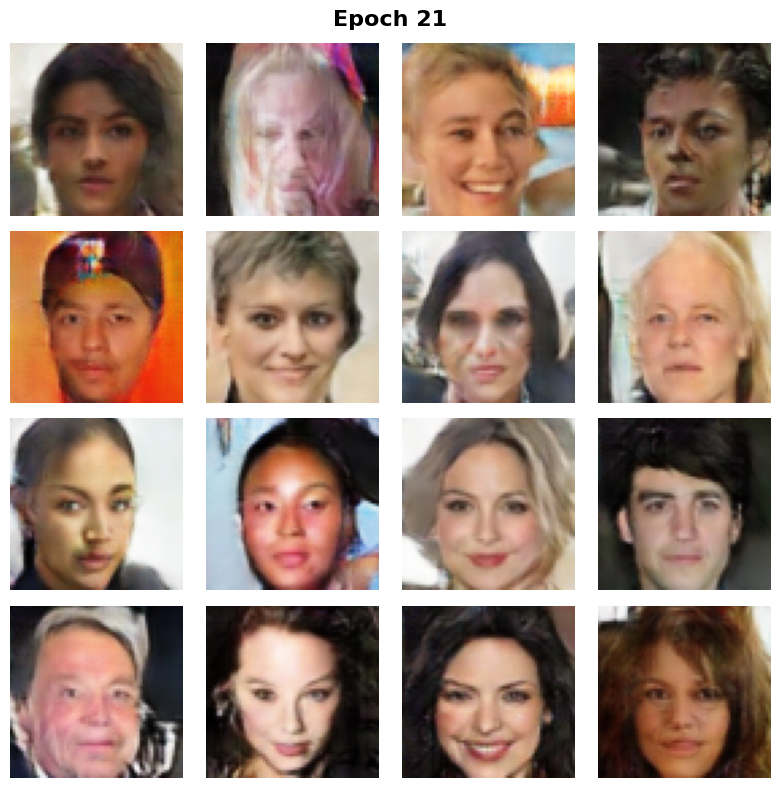


🔥 Epoch 22/50
  [  50/791] D Loss: 0.6431 | G Loss: 2.3625
  [ 100/791] D Loss: 0.5719 | G Loss: 2.4465
  [ 150/791] D Loss: 0.5726 | G Loss: 2.4874
  [ 200/791] D Loss: 0.6715 | G Loss: 2.3974
  [ 250/791] D Loss: 0.5735 | G Loss: 2.4704


KeyboardInterrupt: 

In [15]:
# 학습 실행
print("\n" + "=" * 60)
print("🔥 DCGAN 학습 시작 (CelebA - TensorFlow)")
print("=" * 60)
print(f"총 에폭: {EPOCHS}")
print(f"배치 크기: {BATCH_SIZE}")
print(f"총 배치 수: {num_images // BATCH_SIZE}")
print("=" * 60)

# 학습 기록
history = {
    'd_loss': [],
    'g_loss': [],
    'epoch_time': []
}

num_batches = num_images // BATCH_SIZE

# 학습 시작
for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    print(f"\n{'='*60}")
    print(f"🔥 Epoch {epoch}/{EPOCHS}")
    print(f"{'='*60}")

    epoch_d_loss = []
    epoch_g_loss = []

    for batch_idx, real_batch in enumerate(train_dataset):
        d_loss, g_loss = train_step(real_batch)

        epoch_d_loss.append(d_loss.numpy())
        epoch_g_loss.append(g_loss.numpy())

        if (batch_idx + 1) % DISPLAY_INTERVAL == 0:
            avg_d = np.mean(epoch_d_loss[-DISPLAY_INTERVAL:])
            avg_g = np.mean(epoch_g_loss[-DISPLAY_INTERVAL:])
            print(f"  [{batch_idx + 1:4d}/{num_batches}] "
                  f"D Loss: {avg_d:.4f} | G Loss: {avg_g:.4f}")

    avg_d_loss = np.mean(epoch_d_loss)
    avg_g_loss = np.mean(epoch_g_loss)

    history['d_loss'].append(avg_d_loss)
    history['g_loss'].append(avg_g_loss)

    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)

    print(f"\n{'='*60}")
    print(f"📊 Epoch {epoch} 완료")
    print(f"{'='*60}")
    print(f"  평균 D Loss: {avg_d_loss:.4f}")
    print(f"  평균 G Loss: {avg_g_loss:.4f}")
    print(f"  소요 시간: {epoch_time:.1f}초")
    print(f"{'='*60}")

    if epoch % SAVE_INTERVAL == 0:
        clear_output(wait=True)
        generate_and_save_images(epoch, generator, fixed_seed)

print("\n✅ 학습 완료!")

## 1️⃣1️⃣ 학습 결과 분석

In [ ]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['d_loss'], label='Discriminator Loss', color='blue', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Discriminator Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['g_loss'], label='Generator Loss', color='red', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Generator Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['epoch_time'], label='Time per Epoch', color='green', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 최종 생성 이미지
print("🎨 최종 생성 이미지 (25개 샘플)")

final_noise = tf.random.normal([25, NOISE_DIM])
final_images = generator(final_noise, training=False)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = (final_images[i].numpy() + 1) / 2
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("DCGAN 최종 생성 이미지 (CelebA - TensorFlow)",
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# GPU 메모리 사용량 확인
print("\n" + "=" * 60)
print("💾 GPU 메모리 사용량 확인")
print("=" * 60)
!nvidia-smi --query-gpu=memory.used,memory.total --format=csv
print("=" * 60)

---
# 🎨 DCGAN with CelebA (PyTorch)

**학습 목표:**
- Kaggle에서 CelebA 데이터셋 다운로드
- L4 GPU 리소스 최적화 (BATCH_SIZE=256)
- 고품질 얼굴 이미지 생성

**환경:**
- Google Colab L4 GPU (24GB)
- PyTorch 2.x
- Automatic Mixed Precision (AMP)
---

## 1️⃣ Kaggle API 설정 및 데이터셋 다운로드

In [ ]:
# Kaggle API 설치
!pip install -q kaggle

In [ ]:
# Kaggle 인증 정보 설정
import os
os.environ["KAGGLE_USERNAME"] = ""
os.environ["KAGGLE_KEY"] = ""

print("✅ Kaggle API 인증 완료")

In [ ]:
# # CelebA 데이터셋 다운로드
# print("📥 CelebA 데이터셋 다운로드 중...")
# print("(약 1.3GB - 시간이 소요됩니다)")

# # 디렉토리 생성
# !mkdir -p celeba

# # Kaggle에서 다운로드
# !kaggle datasets download -d jessicali9530/celeba-dataset -p ./celeba -q

# # 압축 해제
# print("\n📦 압축 해제 중...")
# !unzip -q ./celeba/celeba-dataset.zip -d ./celeba

# print("\n✅ 데이터셋 다운로드 완료")

## 2️⃣ 환경 설정 및 라이브러리 임포트

In [17]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from IPython.display import clear_output

# GPU 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# CUDNN 벤치마크 활성화
torch.backends.cudnn.benchmark = True

# Automatic Mixed Precision (AMP) 설정
USE_AMP = True
if USE_AMP:
    print(f"\n✅ Automatic Mixed Precision (AMP) 활성화")

# 랜덤 시드 설정
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

PyTorch 버전: 2.9.0+cu126
CUDA 사용 가능: True
CUDA 버전: 12.6
GPU 이름: NVIDIA L4
GPU 메모리: 23.80 GB

✅ Automatic Mixed Precision (AMP) 활성화


## 3️⃣ 하이퍼파라미터 설정 (GPU 최적화)

In [18]:
# ========================================
# 하이퍼파라미터 설정
# ========================================
# L4 GPU: 24GB VRAM, Tensor Core 지원
# BATCH_SIZE를 256으로 증가

# 이미지 설정
IMG_SIZE = 64  # CelebA 표준: 64×64
CHANNELS = 3  # RGB

# 학습 설정
BATCH_SIZE = 256  # 128 → 256 증가 (GPU 메모리 효율적 사용)
NOISE_DIM = 100  # 노이즈 벡터 차원
EPOCHS = 50  # 총 학습 에폭

# Optimizer 설정 (DCGAN 표준)
LR_G = 0.0002  # Generator 학습률
LR_D = 0.0002  # Discriminator 학습률
BETA1 = 0.5  # Adam optimizer beta1
BETA2 = 0.999  # Adam optimizer beta2

# 출력 설정
SAVE_INTERVAL = 3  # 이미지 생성 간격 (에폭)
DISPLAY_INTERVAL = 50  # Loss 출력 간격 (배치)

# DataLoader 설정
NUM_WORKERS = 2  # 데이터 로딩 워커 수

print("=" * 60)
print("🔧 하이퍼파라미터 설정")
print("=" * 60)
print(f"이미지 크기: {IMG_SIZE}×{IMG_SIZE}×{CHANNELS}")
print(f"배치 크기: {BATCH_SIZE} (GPU 최적화)")
print(f"노이즈 차원: {NOISE_DIM}")
print(f"학습 에폭: {EPOCHS}")
print(f"학습률 (G/D): {LR_G} / {LR_D}")
print(f"AMP (자동 혼합 정밀도): {USE_AMP}")
print(f"DataLoader 워커: {NUM_WORKERS}")
print("=" * 60)

🔧 하이퍼파라미터 설정
이미지 크기: 64×64×3
배치 크기: 256 (GPU 최적화)
노이즈 차원: 100
학습 에폭: 50
학습률 (G/D): 0.0002 / 0.0002
AMP (자동 혼합 정밀도): True
DataLoader 워커: 2


## 4️⃣ 데이터셋 로드 및 PyTorch Dataset 구성

In [19]:
# ========================================
# PyTorch Dataset 클래스 정의
# ========================================
class CelebADataset(Dataset):
    """
    CelebA 데이터셋 (로컬 파일 사용)

    전처리 과정:
        1. 이미지 로드 (PIL)
        2. CenterCrop(140): 얼굴 중심 crop
        3. Resize(64): 64×64로 축소
        4. ToTensor: [0, 1] 범위로 변환
        5. Normalize: [-1, 1] 범위로 정규화
    """

    def __init__(self, img_dir, transform=None):
        """
        Args:
            img_dir: 이미지 디렉토리 경로
            transform: torchvision.transforms 파이프라인
        """
        self.img_dir = Path(img_dir)
        self.transform = transform

        # 모든 .jpg 파일 경로 수집
        self.image_paths = sorted(list(self.img_dir.glob("*.jpg")))

        print(f"   - 데이터셋 경로: {self.img_dir}")
        print(f"   - 총 이미지 수: {len(self.image_paths):,}장")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx: 인덱스

        Returns:
            image: 전처리된 이미지 Tensor (3, 64, 64), 범위 [-1, 1]
        """
        # 이미지 로드
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        # 원본 크기: (178, 218) - PIL은 (W, H) 순서

        # 전처리 적용
        if self.transform:
            image = self.transform(image)

        return image


# ========================================
# 데이터 전처리 파이프라인
# ========================================
# CelebA 원본 이미지는 178×218 크기
# 전처리 과정:
#   1. CenterCrop(140): 얼굴 중심 부분을 140×140으로 crop
#   2. Resize(64): 64×64로 축소
#   3. ToTensor: PIL Image → Tensor, [0, 1] 범위
#   4. Normalize: [-1, 1] 범위로 정규화
transform = transforms.Compose([
    transforms.CenterCrop(140),  # 중심 140×140 crop
    transforms.Resize(IMG_SIZE),  # 64×64로 resize
    transforms.ToTensor(),  # PIL → Tensor, [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # [-1, 1] 정규화
])

# ========================================
# 데이터셋 및 DataLoader 생성
# ========================================
print("\n🔄 PyTorch Dataset 및 DataLoader 생성 중...")

# 이미지 디렉토리 경로
IMG_DIR = Path("celeba") / "img_align_celeba" / "img_align_celeba"

# Dataset 생성
train_dataset = CelebADataset(
    img_dir=IMG_DIR,
    transform=transform
)

# DataLoader 생성
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # 에폭마다 셔플
    num_workers=NUM_WORKERS,  # 멀티프로세싱
    pin_memory=True,  # GPU 전송 속도 향상
    drop_last=True,  # 마지막 불완전한 배치 제거
    persistent_workers=True if NUM_WORKERS > 0 else False  # 워커 재사용
)

print(f"\n✅ DataLoader 준비 완료")
print(f"   - 배치 크기: {BATCH_SIZE}")
print(f"   - 총 배치 수: {len(train_dataloader)}")
print(f"   - 워커 수: {NUM_WORKERS}")


🔄 PyTorch Dataset 및 DataLoader 생성 중...
   - 데이터셋 경로: celeba/img_align_celeba/img_align_celeba
   - 총 이미지 수: 202,599장

✅ DataLoader 준비 완료
   - 배치 크기: 256
   - 총 배치 수: 791
   - 워커 수: 2



🎨 데이터 샘플 확인
배치 shape: torch.Size([256, 3, 64, 64])
배치 dtype: torch.float32
값 범위: [-1.00, 1.00]


/tmp/ipython-input-3572644703.py:25: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3572644703.py:25: UserWarning: Glyph 52376 (\N{HANGUL SYLLABLE CEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3572644703.py:25: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3572644703.py:25: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3572644703.py:25: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning

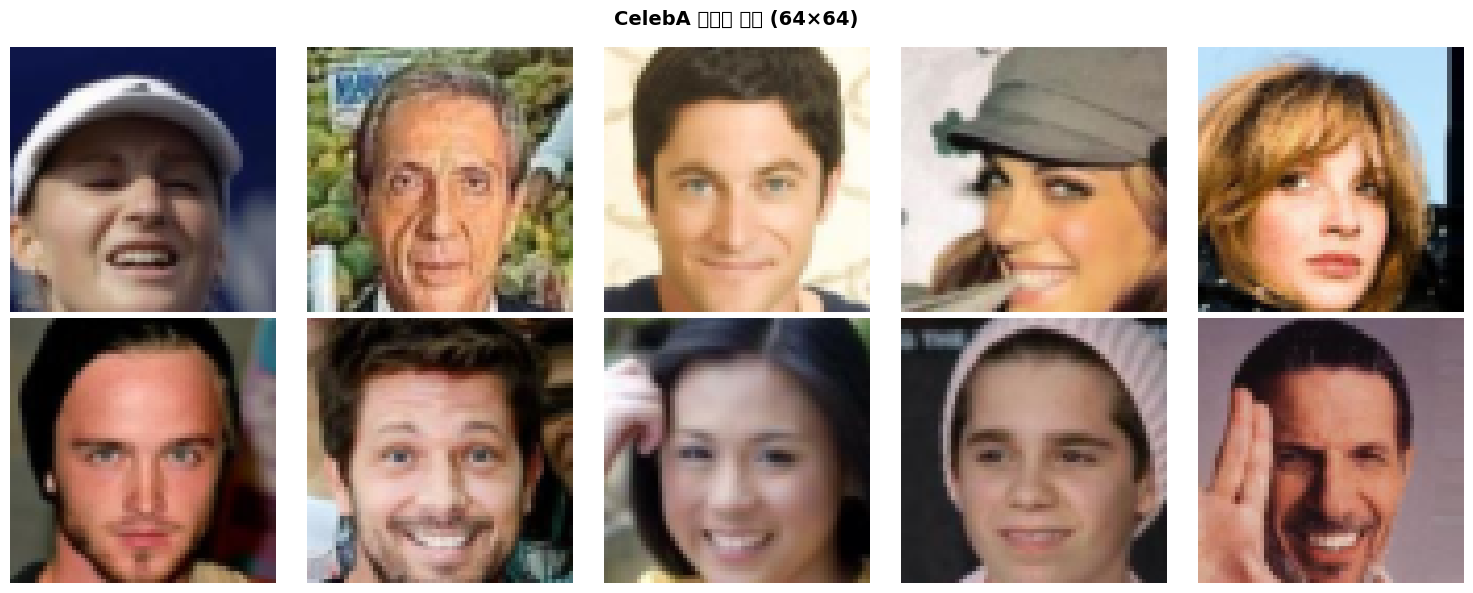

In [20]:
# ========================================
# 데이터 샘플 시각화
# ========================================
print("\n🎨 데이터 샘플 확인")

# 첫 번째 배치 가져오기
sample_batch = next(iter(train_dataloader))
print(f"배치 shape: {sample_batch.shape}")  # (256, 3, 64, 64)
print(f"배치 dtype: {sample_batch.dtype}")  # torch.float32
print(f"값 범위: [{sample_batch.min():.2f}, {sample_batch.max():.2f}]")

# 시각화
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # [-1, 1] → [0, 1] 변환
    # PyTorch: (C, H, W) → (H, W, C)로 변환
    img = sample_batch[i].numpy()
    img = (img + 1) / 2
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')

plt.suptitle("CelebA 전처리 샘플 (64×64)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5️⃣ Generator 구현 (DCGAN 아키텍처)

In [21]:
class Generator(nn.Module):
    """
    DCGAN Generator 구현

    아키텍처:
        Input: 노이즈 벡터 (batch_size, 100, 1, 1)
        Layer 1: ConvTranspose2d(1024) + BN + ReLU → (batch_size, 1024, 4, 4)
        Layer 2: ConvTranspose2d(512) + BN + ReLU → (batch_size, 512, 8, 8)
        Layer 3: ConvTranspose2d(256) + BN + ReLU → (batch_size, 256, 16, 16)
        Layer 4: ConvTranspose2d(128) + BN + ReLU → (batch_size, 128, 32, 32)
        Layer 5: ConvTranspose2d(3) + Tanh → (batch_size, 3, 64, 64)
    """

    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Layer 1: ConvTranspose2d (1×1 → 4×4)
            nn.ConvTranspose2d(noise_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            # Layer 2: ConvTranspose2d (4×4 → 8×8)
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # Layer 3: ConvTranspose2d (8×8 → 16×16)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # Layer 4: ConvTranspose2d (16×16 → 32×32)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Layer 5: ConvTranspose2d (32×32 → 64×64) - 출력층
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        """순전파"""
        return self.main(z)


# 가중치 초기화 함수
def weights_init(m):
    """DCGAN 표준 가중치 초기화"""
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Generator 생성 및 초기화
generator = Generator(NOISE_DIM).to(device)
generator.apply(weights_init)

print("\n📊 Generator 구조:")
print("=" * 60)
print(generator)
print("=" * 60)


📊 Generator 구조:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


## 6️⃣ Discriminator 구현 (DCGAN 아키텍처)

In [22]:
class Discriminator(nn.Module):
    """
    DCGAN Discriminator 구현

    아키텍처:
        Input: 이미지 (batch_size, 3, 64, 64)
        Layer 1: Conv2d(64) + LeakyReLU → (batch_size, 64, 32, 32)
        Layer 2: Conv2d(128) + BN + LeakyReLU → (batch_size, 128, 16, 16)
        Layer 3: Conv2d(256) + BN + LeakyReLU → (batch_size, 256, 8, 8)
        Layer 4: Conv2d(512) + BN + LeakyReLU → (batch_size, 512, 4, 4)
        Layer 5: Conv2d(1) → (batch_size, 1, 1, 1)
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Layer 1: Conv2d (64×64 → 32×32) - 입력층
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 2: Conv2d (32×32 → 16×16)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3: Conv2d (16×16 → 8×8)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 4: Conv2d (8×8 → 4×4)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 5: Conv2d (4×4 → 1×1) - 출력층
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        """순전파"""
        output = self.main(x)
        return output.view(-1)


# Discriminator 생성 및 초기화
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

print("\n📊 Discriminator 구조:")
print("=" * 60)
print(discriminator)
print("=" * 60)


📊 Discriminator 구조:
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


## 7️⃣ 손실 함수 및 Optimizer 설정

In [23]:
# BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# Optimizer 설정
optimizer_g = optim.Adam(
    generator.parameters(),
    lr=LR_G,
    betas=(BETA1, BETA2)
)

optimizer_d = optim.Adam(
    discriminator.parameters(),
    lr=LR_D,
    betas=(BETA1, BETA2)
)

# GradScaler 설정 (AMP용)
scaler = GradScaler(enabled=USE_AMP)

print("✅ 손실 함수 및 Optimizer 설정 완료")
if USE_AMP:
    print(f"   - GradScaler: 활성화")

✅ 손실 함수 및 Optimizer 설정 완료
   - GradScaler: 활성화


/tmp/ipython-input-1814606325.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=USE_AMP)


## 8️⃣ 학습 Step 함수 구현

In [24]:
def train_step(real_images):
    """DCGAN 한 스텝 학습 (PyTorch + AMP)"""
    batch_size = real_images.size(0)
    real_images = real_images.to(device)

    # 라벨 생성
    real_labels = torch.ones(batch_size, device=device)
    fake_labels = torch.zeros(batch_size, device=device)

    # ========================================
    # 1. Discriminator 학습
    # ========================================
    discriminator.zero_grad()

    with autocast(enabled=USE_AMP):
        # 진짜 이미지 판별
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)

        # 가짜 이미지 생성 및 판별
        noise = torch.randn(batch_size, NOISE_DIM, 1, 1, device=device)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        # Discriminator 총 손실
        d_loss = d_loss_real + d_loss_fake

    # Discriminator 역전파 및 업데이트
    scaler.scale(d_loss).backward()
    scaler.step(optimizer_d)
    scaler.update()

    # ========================================
    # 2. Generator 학습
    # ========================================
    generator.zero_grad()

    with autocast(enabled=USE_AMP):
        # 새로운 노이즈로 가짜 이미지 생성
        noise = torch.randn(batch_size, NOISE_DIM, 1, 1, device=device)
        fake_images = generator(noise)

        # Discriminator로 판별
        fake_output = discriminator(fake_images)

        # Generator 손실
        g_loss = criterion(fake_output, real_labels)

    # Generator 역전파 및 업데이트
    scaler.scale(g_loss).backward()
    scaler.step(optimizer_g)
    scaler.update()

    return d_loss.item(), g_loss.item()


print("✅ train_step 함수 정의 완료")

✅ train_step 함수 정의 완료


## 9️⃣ 이미지 생성 및 시각화 함수

🎨 학습 전 Generator 출력


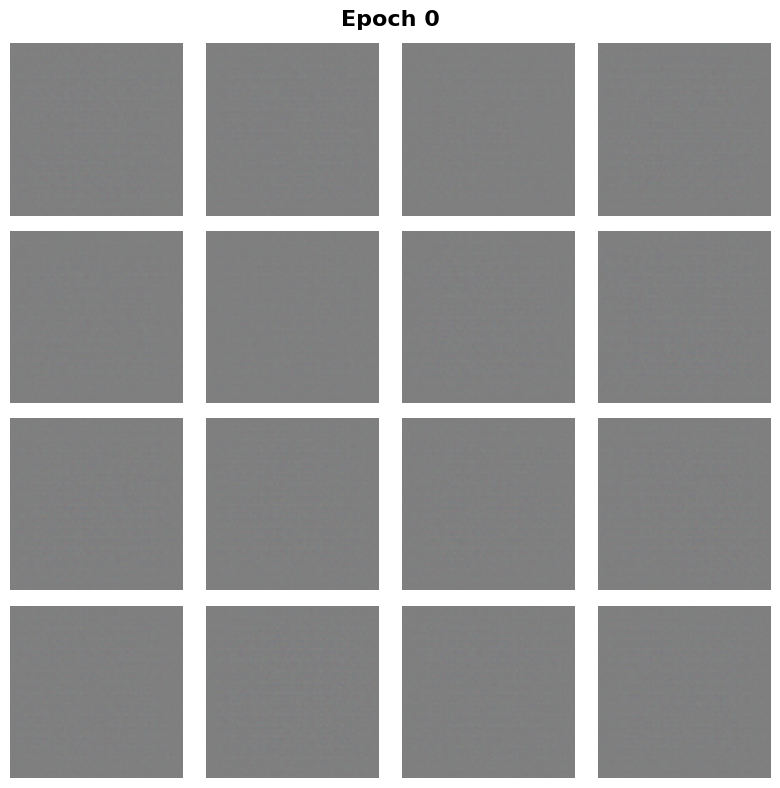

In [25]:
# 고정 노이즈 시드
num_examples_to_generate = 16
fixed_noise = torch.randn(num_examples_to_generate, NOISE_DIM, 1, 1, device=device)


def generate_and_save_images(epoch, generator, noise):
    """Generator로 이미지 생성 및 시각화"""
    generator.eval()

    with torch.no_grad():
        fake_images = generator(noise).cpu()

    fig = plt.figure(figsize=(8, 8))

    for i in range(fake_images.size(0)):
        plt.subplot(4, 4, i + 1)
        img = fake_images[i].numpy()
        img = (img + 1) / 2
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    generator.train()


# 초기 이미지 생성
print("🎨 학습 전 Generator 출력")
generate_and_save_images(0, generator, fixed_noise)

## 🔟 전체 학습 루프 실행

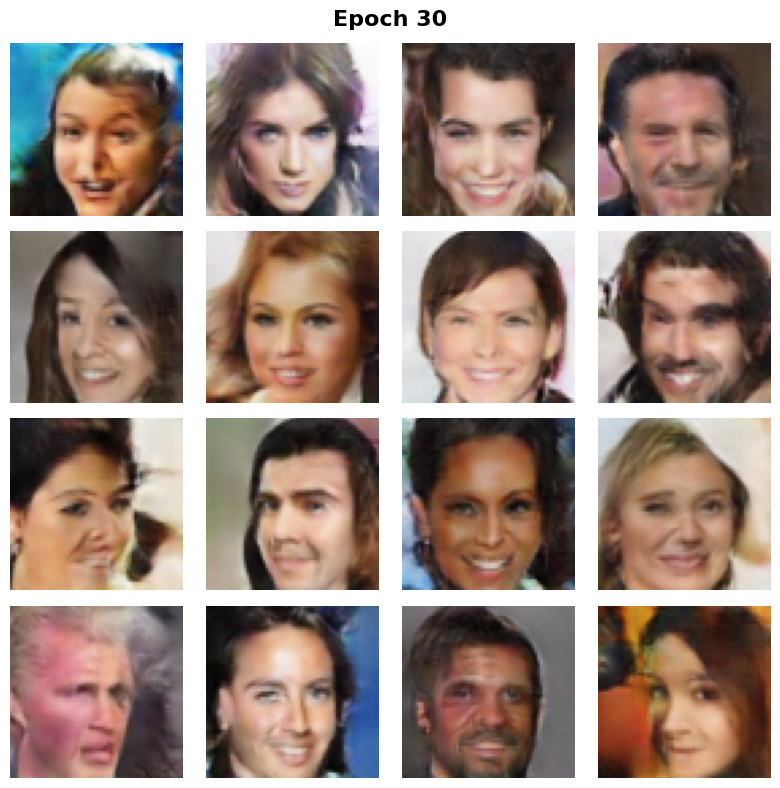


🔥 Epoch 31/50
  [  50/791] D Loss: 0.5453 | G Loss: 3.1983
  [ 100/791] D Loss: 0.4155 | G Loss: 3.2011


KeyboardInterrupt: 

In [26]:
# 학습 실행
print("\n" + "=" * 60)
print("🔥 DCGAN 학습 시작 (CelebA - PyTorch)")
print("=" * 60)
print(f"총 에폭: {EPOCHS}")
print(f"배치 크기: {BATCH_SIZE}")
print(f"총 배치 수: {len(train_dataloader)}")
print("=" * 60)

# 학습 기록
history = {
    'd_loss': [],
    'g_loss': [],
    'epoch_time': []
}

num_batches = len(train_dataloader)

# 학습 시작
for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    print(f"\n{'='*60}")
    print(f"🔥 Epoch {epoch}/{EPOCHS}")
    print(f"{'='*60}")

    epoch_d_loss = []
    epoch_g_loss = []

    for batch_idx, real_batch in enumerate(train_dataloader):
        d_loss, g_loss = train_step(real_batch)

        epoch_d_loss.append(d_loss)
        epoch_g_loss.append(g_loss)

        if (batch_idx + 1) % DISPLAY_INTERVAL == 0:
            avg_d = np.mean(epoch_d_loss[-DISPLAY_INTERVAL:])
            avg_g = np.mean(epoch_g_loss[-DISPLAY_INTERVAL:])
            print(f"  [{batch_idx + 1:4d}/{num_batches}] "
                  f"D Loss: {avg_d:.4f} | G Loss: {avg_g:.4f}")

    avg_d_loss = np.mean(epoch_d_loss)
    avg_g_loss = np.mean(epoch_g_loss)

    history['d_loss'].append(avg_d_loss)
    history['g_loss'].append(avg_g_loss)

    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)

    print(f"\n{'='*60}")
    print(f"📊 Epoch {epoch} 완료")
    print(f"{'='*60}")
    print(f"  평균 D Loss: {avg_d_loss:.4f}")
    print(f"  평균 G Loss: {avg_g_loss:.4f}")
    print(f"  소요 시간: {epoch_time:.1f}초")
    print(f"{'='*60}")

    if epoch % SAVE_INTERVAL == 0:
        clear_output(wait=True)
        generate_and_save_images(epoch, generator, fixed_noise)

print("\n✅ 학습 완료!")

## 1️⃣1️⃣ 학습 결과 분석

In [ ]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['d_loss'], label='Discriminator Loss', color='blue', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Discriminator Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['g_loss'], label='Generator Loss', color='red', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Generator Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['epoch_time'], label='Time per Epoch', color='green', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 최종 생성 이미지
print("🎨 최종 생성 이미지 (25개 샘플)")

generator.eval()
with torch.no_grad():
    final_noise = torch.randn(25, NOISE_DIM, 1, 1, device=device)
    final_images = generator(final_noise).cpu()

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = final_images[i].numpy()
    img = (img + 1) / 2
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("DCGAN 최종 생성 이미지 (CelebA - PyTorch)",
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# GPU 메모리 사용량 확인
print("\n" + "=" * 60)
print("💾 GPU 메모리 사용량 확인")
print("=" * 60)
!nvidia-smi --query-gpu=memory.used,memory.total --format=csv
print("=" * 60)